----
# Setup

## Configure Colab File System

Make sure you shortcut the lfqa_266 folder to MyDrive!
> `lfqa_266` -> `Organize` -> `Add shortcut`



![](https://drive.google.com/uc?export=view&id=1sxFMcaAAWTGfFYyTlmvFZmEgfNdeU0Ks)

<br></br>


----
## Stay Connected to Colab Runtime
If you want to let your colab keep running while you're gone, copy-paste this into the editor console:
> - `option` + `command` + `i`
- `copy-paste` the snippet into the *console*, then hit `enter`
- check for printouts at 60s mark, then run your job

```javascript
function ClickConnect(){
    console.log("Click #1");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect,60000);
```

<br></br>


## `Choose what to run`

`run_experiments - green light to train the model?`

`evaluate_experiments - green light to evaluate the model?`

In [ ]:
CUDA_LAUNCH_BLOCKING="1"
run_experiments = True
run_evaluation = True
run_eda = False

----
## Install Packages & Dependencies

In [ ]:
# @title
import importlib

def install_if_needed(package_names):
    """
    Install one or more Python packages using pip if they are not already installed.

    Args:
        package_names (str or list): The name(s) of the package(s) to install.

    Returns:
        None
    """
    print('installing packages')
    if isinstance(package_names, str):
        package_names = [package_names]

    newly_installed = []
    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"- {package_name} is already installed.")
        except ImportError:
            !pip install --quiet {package_name} --upgrade
            newly_installed.append(package_name)

    print(f"- installed {', '.join(newly_installed)}")
    print(f"- imported {', '.join([x for x in package_names if x not in newly_installed])}")


def running_in_colab():
    """
    Check if the Jupyter Notebook is running in Google Colab.

    Returns:
        bool: True if running in Google Colab, False otherwise.
    """
    try:
        import google.colab

        return True
    except ImportError:
        return False


def mount_to_drive():
    """
    Mount notebook to colab file directory
    """
    if running_in_colab():
      print('\tmounting to drive')
      from google.colab import drive
      drive.mount("/content/drive", force_remount=True)


def unpack_elasticsearch():
  """
  Get elasticsearch jar file if necessary
  """
  ![[ -d /content/elasticsearch-8.11.1 ]] && echo "- elasticsearch is already installed" \
                                           || wget "https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.11.1-linux-x86_64.tar.gz" \
                                                && tar -xzf "elasticsearch-8.11.1-linux-x86_64.tar.gz" 1> /dev/null && echo "- elasticsearch has been installed"

def fakeout():
  print('not today son!')
  return None, None

In [ ]:
ROOT='/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/'
packages = [
  # "faiss",
  # "dill",
  "accelerate",
  "apache-beam",
  "datasets",
  # "elasticsearch",
  # "faiss_gpu",
  "evaluate",
  "nlp",
  "python-dotenv",
  "rouge_score",
  "sentencepiece",
  "sentence-transformers",
  "transformers",
  "torch",
  # "git+https://github.com/huggingface/transformers", # source install for checkpointing
  "pretty_midi",
  "pypianoroll"
]
# rip
install_if_needed(packages)
mount_to_drive()
# unpack_elasticsearch()

# system stuff
from collections import Counter
from datetime import datetime
from dotenv import dotenv_values
dotenv = dotenv_values(f"{ROOT}/.env")
import numpy as np
import pandas as pd
import random
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import sys
sys.path.append(ROOT)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# big boiz
from datasets import load_dataset, Dataset, load_metric, load_dataset_builder
from huggingface_hub import login, logout
import nlp
import rouge_score
from sentence_transformers import CrossEncoder, SentenceTransformer
import tensorflow as tf
import torch
from tensorflow import keras
from transformers import BartTokenizer, BartTokenizerFast, BartForConditionalGeneration, MBart50TokenizerFast
# from transformers import T5Tokenizer, T5ForConditionalGeneration, TFT5ForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer


import pretty_midi
import pypianoroll

import joblib
import glob

import numpy as np
import pandas as pd

import collections
import tables

import os
import shutil
import json
# hide output of this cell
# %%capture_output

installing packages
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.9 MB/s eta 0:00:00

In [ ]:
# # reinstall torch to avoid weird error https://stackoverflow.com/a/77199918
# %pip install torch --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117


# extra - DONT RUN -- create special tokens

In [ ]:
# pd.read_csv(dotenv['loaf_train'],

In [ ]:
# row_order[:load_start]
# row_order[load_end:]

array([], dtype=int64)

In [ ]:
# decided by iterator
idx=1
max_load_at_once=8
n_examples = pd.read_csv(cfg['params']['train_data_filepath']).shape[0]
row_order = np.arange(1, n_examples + 1)

# batch it
load_start = idx
load_end = idx + max_load_at_once

# Indices to skip are the ones in the shuffled row_order before and
# after the chunk we'll use for this chunk
load_idx_skip = row_order[:load_start] + row_order[load_end:]
df_curr_loaded = pd.read_csv(cfg['params']['train_data_filepath'], skiprows=load_idx_skip)

In [ ]:
chunk = df_curr_loaded[['lyric_summary_bart', 'orig_syl_tokens', 'orig_note_onsets_tokens', 'orig_note_dur_tokens', 'orig_note_pitch_tokens', 'orig_note_stress_tokens', 'target']].values.astype(str)[0]

In [ ]:
summary, syls, note_onsets, note_durs, note_pitches, note_stresses, target = chunk

## Instantiate Tokenizer

In [ ]:
len(np.arange(1,25)) + len(np.arange(0.0, 300.0, 0.1)) + len(np.arange(0, 128)) + len(np.arange(0,3))

3155

In [ ]:
model = BartForConditionalGeneration.from_pretrained(cfg['model']['pretrain'])
tokenizer = BartTokenizer.from_pretrained(cfg['model']['pretrain'])
tokenizer.pad_token = tokenizer.eos_token
special_tokens = [f'len_{i}' for i in np.arange(1,25)] + \
                  [f'{x}s' for x in np.round(np.arange(0.0, 300.0, 0.1), 1)] + \
                  [f'pitch_{x}' for x in np.arange(0, 128)] + \
                  [f'str_{x}' for x in np.arange(0, 3)]


tokenizer.add_tokens(special_tokens)
# tokenizer.add_special_tokens({'additional_special_tokens':special_tokens})
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(53420, 1024)

In [ ]:
tokenizer.vocab_size

50265

In [ ]:
model.config.vocab_size

53420

In [ ]:
{n:p.shape for n, p in model.named_parameters() if "embedding" in n}

{'model.encoder.layernorm_embedding.weight': torch.Size([1024]),
 'model.encoder.layernorm_embedding.bias': torch.Size([1024]),
 'model.decoder.layernorm_embedding.weight': torch.Size([1024]),
 'model.decoder.layernorm_embedding.bias': torch.Size([1024])}

In [ ]:
max_length=512
tensor_type='pt'

### Encode Summaries

In [ ]:

# SUMMARY
summ_encoded = tokenizer.batch_encode_plus(
    [summary],
    max_length=int((int(max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)
# extract encoded features (todo: keras v. pytorch?)
summ_input_ids = summ_encoded['input_ids'][0]
summ_attention_mask = summ_encoded['attention_mask'][0]


In [ ]:
summ_encoded['input_ids'].shape

torch.Size([1, 104])

### Encode Syllables

In [ ]:
### SYLLABLES
syl_encoded = tokenizer.batch_encode_plus(
    [syls],
    max_length=int((int(2*max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)
# extract encoded features (todo: keras v. pytorch?)
syl_input_ids = syl_encoded['input_ids'][0]
syl_attention_mask = syl_encoded['attention_mask'][0]


### Encode Notes

In [ ]:
### NOTE ONSETS
note_onsets_encoded = tokenizer.batch_encode_plus(
    [note_onsets],
    max_length=int((int(2*max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)
# extract encoded features (todo: keras v. pytorch?)
note_onsets_input_ids = note_onsets_encoded['input_ids'][0]
note_onsets_attention_mask = note_onsets_encoded['attention_mask'][0]


In [ ]:
### NOTE DURATIONS
note_durs_encoded = tokenizer.batch_encode_plus(
    [note_durs],
    max_length=int((int(2*max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)
# extract encoded features (todo: keras v. pytorch?)
note_durs_input_ids = note_durs_encoded['input_ids'][0]
note_durs_attention_mask = note_durs_encoded['attention_mask'][0]

### NOTE PITCHES
note_pitches_encoded = tokenizer.batch_encode_plus(
    [note_pitches],
    max_length=int((int(2*max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)
# extract encoded features (todo: keras v. pytorch?)
note_pitches_input_ids = note_pitches_encoded['input_ids'][0]
note_pitches_attention_mask = note_pitches_encoded['attention_mask'][0]

### NOTE STRESSES
note_stresses_encoded = tokenizer.batch_encode_plus(
    [note_stresses],
    max_length=int((int(2*max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)
# extract encoded features (todo: keras v. pytorch?)
note_stresses_input_ids = note_stresses_encoded['input_ids'][0]
note_stresses_attention_mask = note_stresses_encoded['attention_mask'][0]

# encode ground truth
target_encoded = tokenizer.batch_encode_plus(
    [target],
    max_length=int((int(2*max_length / 500) * 100) + int((max_length % 100)/3)),
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors=tensor_type,
)

# convert to array
label_ids = target_encoded['input_ids'][0]

### Sum / Concatenate

In [ ]:
note_summed_input_ids = torch.stack([note_onsets_input_ids, note_durs_input_ids, note_pitches_input_ids, note_stresses_input_ids]).sum(dim=0)

In [ ]:
note_onsets_input_ids.shape

torch.Size([204])

In [ ]:
note_summed_input_ids.shape

torch.Size([204])

In [ ]:
# get mean of attention mask & round to 1
note_mean_attention_mask = torch.round(torch.stack([note_onsets_attention_mask*1.0, note_durs_attention_mask*1.0, note_pitches_attention_mask*1.0, note_stresses_attention_mask*1.0]).mean(dim=0))


In [ ]:
# note_stresses_attention_mask

In [ ]:
orig_input_ids = torch.cat((summ_input_ids, syl_input_ids, note_summed_input_ids), dim=0)


In [ ]:
orig_input_ids.shape

torch.Size([512])

In [ ]:

# concatenate with our other inputs
orig_input_ids = torch.cat((summ_input_ids, syl_input_ids, note_summed_input_ids), 0)
orig_attention_mask = torch.cat((summ_attention_mask, syl_attention_mask, note_mean_attention_mask), 0)


In [ ]:
print(orig_syls[0])
print(orig_syls[1])

In [ ]:
orig_input_ids

tensor([    0, 12350, 33542, 20336,   102,  5363,     4,  3791,    38,   393,
         1467,    47,    23,    70,     4,   370,    56,     5, 11564,     7,
          946,  2512,     4,   616,   167,   198,    47, 38475,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     0, 50269,  1437,     2,  1437, 50273,
         1437,     2,  1437, 50272,  1437,     2,  1437, 50270,  1437,     2,
         1437, 50269,  1437,     2,  1437, 50273,  1437,     2, 

208.0

In [ ]:
max_length

In [ ]:
max_length//5

102

In [ ]:
(max_length % 100)/3

4.0

In [ ]:
int((int(2*max_length / 500) * 100) + int((max_length % 100)/3))


204

# Functions

----
## Data Iterator

In [ ]:
class LOAFDataIterator:
    def __init__(self, tokenizer, tensor_type, n_examples, max_load_at_once,
                       data_filename, max_length=1028, shuffle=True):

        self.tokenizer = tokenizer
        self.tensor_type = tensor_type
        self.n_examples = n_examples
        self.max_load_at_once = max_load_at_once
        self.data_filename = data_filename
        self.max_length = max_length
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

        # Load first chunk of max_load_at_once examples
        self.df_curr_loaded = self._load_next_chunk(0)
        self.curr_idx_in_load = 0

    def _load_next_chunk(self, idx):
        load_start = idx
        load_end = idx + self.max_load_at_once

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this chunk
        load_idx_skip = self.row_order[:load_start] + self.row_order[load_end:]
        self.df_curr_loaded = pd.read_csv(self.data_filename, skiprows=load_idx_skip)
        self.df_curr_loaded = self.df_curr_loaded.sample(frac=1)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        if self.df_curr_loaded is None or self.curr_idx_in_load >= len(self.df_curr_loaded):
            self._load_next_chunk(idx)
            self.curr_idx_in_load = 0

        # question answer
        cols = self.df_curr_loaded[['lyric_summary_bart', 'orig_syl_tokens', 'orig_note_onsets_tokens', 'orig_note_dur_tokens', 'orig_note_pitch_tokens', 'orig_note_stress_tokens', 'target']].values.astype(str)[self.curr_idx_in_load]
        self.curr_idx_in_load += 1

        # call preprocessing
        item_data = self.preprocess_data(cols)

        return item_data

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

            if i == self.__len__()-1:
                self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

    def preprocess_data(self, data):
      # extract question/answer
      summary, syls, note_onsets, note_durs, note_pitches, note_stresses, target = data

      # SUMMARY
      summ_encoded = self.tokenizer.batch_encode_plus(
          [summary],
          max_length=int((int(self.max_length / 500) * 100) + int((self.max_length % 100)/3)),
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )
      # extract encoded features (todo: keras v. pytorch?)
      summ_input_ids = summ_encoded['input_ids'][0]
      summ_attention_mask = summ_encoded['attention_mask'][0]

      ### SYLLABLES
      syl_encoded = self.tokenizer.batch_encode_plus(
          [syls],
          max_length=int((int(2*self.max_length / 500) * 100) + int((self.max_length % 100)/3)),
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )
      # extract encoded features (todo: keras v. pytorch?)
      syl_input_ids = syl_encoded['input_ids'][0]
      syl_attention_mask = syl_encoded['attention_mask'][0]

      ### NOTE ONSETS
      note_onsets_encoded = self.tokenizer.batch_encode_plus(
          [note_onsets],
          max_length=int((int(2*self.max_length / 500) * 100) + int((self.max_length % 100)/3)),
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )
      # extract encoded features (todo: keras v. pytorch?)
      note_onsets_input_ids = note_onsets_encoded['input_ids'][0]
      note_onsets_attention_mask = note_onsets_encoded['attention_mask'][0]

      ### NOTE DURATIONS
      note_durs_encoded = self.tokenizer.batch_encode_plus(
          [note_durs],
          max_length=int((int(2*self.max_length / 500) * 100) + int((self.max_length % 100)/3)),
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )
      # extract encoded features (todo: keras v. pytorch?)
      note_durs_input_ids = note_durs_encoded['input_ids'][0]
      note_durs_attention_mask = note_durs_encoded['attention_mask'][0]

      ### NOTE PITCHES
      note_pitches_encoded = self.tokenizer.batch_encode_plus(
          [note_pitches],
          max_length=int((int(2*self.max_length / 500) * 100) + int((self.max_length % 100)/3)),
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )
      # extract encoded features (todo: keras v. pytorch?)
      note_pitches_input_ids = note_pitches_encoded['input_ids'][0]
      note_pitches_attention_mask = note_pitches_encoded['attention_mask'][0]

      ### NOTE STRESSES
      note_stresses_encoded = self.tokenizer.batch_encode_plus(
          [note_stresses],
          max_length=int((int(2*self.max_length / 500) * 100) + int((self.max_length % 100)/3)),
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )
      # extract encoded features (todo: keras v. pytorch?)
      note_stresses_input_ids = note_stresses_encoded['input_ids'][0]
      note_stresses_attention_mask = note_stresses_encoded['attention_mask'][0]

      # combine note
      note_summed_input_ids = torch.stack([note_onsets_input_ids, note_durs_input_ids, note_pitches_input_ids, note_stresses_input_ids]).sum(dim=0)
      # this is redundant rn
      note_mean_attention_mask = torch.round(torch.stack([note_onsets_attention_mask*1.0, note_durs_attention_mask*1.0, note_pitches_attention_mask*1.0, note_stresses_attention_mask*1.0]).mean(dim=0))

      # concatenate with our other inputs
      orig_input_ids = torch.cat((summ_input_ids, syl_input_ids, note_summed_input_ids), dim=0)
      orig_attention_mask = torch.cat((summ_attention_mask, syl_attention_mask, note_onsets_attention_mask), dim=0)

      # encode ground truth
      target_encoded = self.tokenizer.batch_encode_plus(
          [target],
          max_length=self.max_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors=self.tensor_type,
      )

      # convert to array
      label_ids = target_encoded['input_ids'][0]

      return {'input_ids': orig_input_ids, 'attention_mask': orig_attention_mask, 'labels': label_ids}

## Model Trainer

In [ ]:
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-large') # todo: changing this to fast
# tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# tokenizer.eos_token

In [ ]:
from ast import Return
from transformers import default_data_collator

def compute_metrics(eval_pred, metric):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels, use_stemmer=True, use_aggregator=True)

    return result


def get_pretrained_model(cfg):
  return BartForConditionalGeneration.from_pretrained(cfg['model']['pretrain'])


def get_lyrlen_tokenizer(cfg):
  tokenizer = BartTokenizer.from_pretrained(cfg['model']['pretrain']) # todo: changing this to fast
  tokenizer.pad_token = tokenizer.eos_token
  special_tokens = [f'{x}s' for x in np.round(np.arange(0.0, 300.0, 0.1), 1)] + \
                   [f'pitch_{x}' for x in np.arange(0, 128)] + \
                   [f'str_{x}' for x in np.arange(0, 3)]

  tokenizer.add_tokens([f'len_{i}' for i in np.arange(1,30)]) # just add as tokens.
  tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
  return tokenizer

def get_data_iterators(cfg, model):
  # get tokenizer
  tokenizer = get_lyrlen_tokenizer(cfg)
  # https://discuss.huggingface.co/t/how-to-train-the-embedding-of-special-token/10837
  model.resize_token_embeddings(len(tokenizer))
  # training data
  train_data_iterator = LOAFDataIterator(
                            tokenizer = tokenizer,
                            tensor_type = cfg['params']['tensor_type'],
                            max_load_at_once = cfg['params']['max_load_at_once'],
                            data_filename = cfg['params']['train_data_filepath'],
                            n_examples = pd.read_csv(cfg['params']['train_data_filepath']).shape[0],
                            max_length=cfg['params']['max_length'],
                         )
  # validation data
  valid_data_iterator = LOAFDataIterator(
                            tokenizer = tokenizer,
                            tensor_type = cfg['params']['tensor_type'],
                            max_load_at_once = cfg['params']['max_load_at_once'],
                            data_filename = cfg['params']['valid_data_filepath'],
                            n_examples = pd.read_csv(cfg['params']['valid_data_filepath']).shape[0],
                            max_length=cfg['params']['max_length'],
                         )

  return (tokenizer, train_data_iterator, valid_data_iterator)


def push_model_to_huggingface(trainer, tokenizer, cfg):
  try:
    login(cfg['dotenv']['hf_write_token_adam'])
    trainer.push_to_hub(cfg['model']['hf_path'])
    tokenizer.push_to_hub(cfg['model']['hf_path'])
  except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
    print("-----------------------------------")
    print('you will need to rewrite this model')
    print("-----------------------------------")
    return False

  return True



def train_pytorch_model(cfg, model, tokenizer, train_data_iterator, valid_data_iterator):
  # create trainer object
  trainer = Seq2SeqTrainer(
                model = model,
                train_dataset = train_data_iterator,
                eval_dataset = valid_data_iterator,
                args = Seq2SeqTrainingArguments(
                            push_to_hub=True,
                            push_to_hub_model_id=cfg['model']['hf_path'],
                            push_to_hub_token=cfg['dotenv']['hf_write_token_adam'],
                            hub_strategy='checkpoint',
                            output_dir = cfg['model']['filepath'],
                            overwrite_output_dir = True,
                            evaluation_strategy = 'steps',
                            eval_steps=500,
                            save_steps=500,
                            logging_steps=500,
                            save_total_limit=2,
                            load_best_model_at_end=True,
                            # learning_rate = 2e-5,
                            per_device_train_batch_size = cfg['params']['batch_size'],
                            per_device_eval_batch_size = cfg['params']['batch_size'],
                            num_train_epochs = cfg['params']['num_train_epochs'],
                            predict_with_generate=True,
                        ),
                data_collator = default_data_collator,
                # compute_metrics=compute_metrics,
              )
  if cfg['resume_from_checkpoint']:
    trainer.train(resume_from_checkpoint=cfg['model']['last_checkpoint'])
  else:
    trainer.train()
  # save model
  print('chaaaaa ching!') if push_model_to_huggingface(trainer, tokenizer, cfg) else print('oh noooooooo')

  # train & save model
  return trainer, tokenizer


def run_training_pipeline(cfg):
  print(cfg)
  # load pretrained model
  model = get_pretrained_model(cfg)
  # torch.cuda.is_available = lambda : False # Force CPU for debug
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  # load data iterators for pytorch
  tokenizer, train_data_iterator, valid_data_iterator = get_data_iterators(cfg, model)
  # resize our special tokens

  # train pytorch model
  trainer, tokenizer = train_pytorch_model(cfg, model, tokenizer, train_data_iterator, valid_data_iterator)

  return trainer, tokenizer

---
## Evaluation

In [ ]:
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import cmudict
import re
# Download the CMU Pronouncing Dictionary if not already downloaded
nltk.download('cmudict')
nltk.download('punkt')

# instantiate dictionary for phonetic syllables
syllable_dict = cmudict.dict()
# constants to be used in manual syllable counting
VOWEL_RUNS = re.compile("[aeiouy]+", flags=re.I)
EXCEPTIONS = re.compile(
    # fixes trailing e issues:
    # smite, scared
    "[^aeiou]e[sd]?$|"
    # fixes adverbs:
    # nicely
    + "[^e]ely$",
    flags=re.I
)
ADDITIONAL = re.compile(
    # fixes incorrect subtractions from exceptions:
    # smile, scarred, raises, fated
    "[^aeioulr][lr]e[sd]?$|[csgz]es$|[td]ed$|"
    # fixes miscellaneous issues:
    # flying, piano, video, prism, fire, evaluate
    + ".y[aeiou]|ia(?!n$)|eo|ism$|[^aeiou]ire$|[^gq]ua",
    flags=re.I
)

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
'''
get_clean_lyric_lines():
    - remove [SECTIONS] & extra newline chars
'''
def get_clean_lyric_lines(input_string):
    # Define a regular expression pattern to match substrings within brackets
    pattern = r'\[.*?\]'
    # Use re.sub() to replace all matches of the pattern with an empty string
    result_string = re.sub(pattern, '', input_string)
    result_string = result_string.replace('\n\n\n\n\n\n','\n').replace('\n\n\n\n\n','\n').replace('\n\n\n\n','\n').replace('\n\n\n','\n').replace('\n\n','\n')
    lines = result_string.split('\n')
    lines = [l for l in lines if l != '']
    return lines

'''
count_word_syllables_man():
    - manually count syllables using ruleset
'''
def count_word_syllables_man(word):
    vowel_runs = len(VOWEL_RUNS.findall(word))
    exceptions = len(EXCEPTIONS.findall(word))
    additional = len(ADDITIONAL.findall(word))
    return max(1, vowel_runs - exceptions + additional)

'''
count_word_syllables_cmu():
    - uses cmu pronunciation dictionary
'''
def count_word_syllables_cmu(word):
  return [len(list(y for y in x if y[-1].isdigit())) for x in syllable_dict[word.lower()]][0]

'''
count_word_syllables():
'''
def count_word_syllables(word):
    try:
        return count_word_syllables_cmu(word)
    except KeyError:
        return count_word_syllables_man(word)

'''
count_line_syllables():
'''
def count_line_syllables(line):
    tokens = word_tokenize(line)
    syllable_counts = [count_word_syllables(token) for token in tokens if token.isalpha()]
    return sum(syllable_counts)

In [ ]:
'''
extract_nested_string_fields()
      - helper to extract nested fields for metrics
'''
def extract_nested_string_fields(ex):
  for col in ex.keys(): ex[col] = ex[col][0] if type(ex[col]) is list else ex[col]
  return ex

'''
generate_lyrics_from_sylls()
      - generate lyrics
'''
def generate_lyrics_from_sylls(hf_dataset, hf_model, num_rows=None):
  # load our test dataset
  login(cfg['dotenv']['hf_read_token_adam'])
  test = load_dataset(hf_dataset, split=f'test[:{num_rows}]')
  tokenizer = BartTokenizer.from_pretrained(hf_model, token=dotenv['hf_read_token_adam'])
  model = BartForConditionalGeneration.from_pretrained(hf_model, token=dotenv['hf_read_token_adam'])
  model.resize_token_embeddings(len(tokenizer))
  # save model & tokenizer to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  # generate
  predictions = []
  labels = []
  for i in range(test.num_rows):
    # get question + context docs
    input_doc = test[i]['orig']
    # tokenize
    model_input = tokenizer(input_doc, truncation=True, padding=True, return_tensors="pt")
    # generate lyrics
    generated_lyrics_encoded = model.generate(input_ids=model_input["input_ids"].to(device),
                                                attention_mask=model_input["attention_mask"].to(device),
                                                min_length=64,
                                                max_length=1028,
                                                # beam search
                                                early_stopping=True,
                                                num_beams=10, #4?
                                                # sampling decoding
                                                do_sample=True,
                                                top_k=0,
                                                top_p=0.8,
                                                temperature=0.6,
                                                # don't repeat chains of 3
                                                no_repeat_ngram_size=3,
                                                num_return_sequences=1
                                              )
    # decode answers to get text
    generated_lyrics = tokenizer.batch_decode(generated_lyrics_encoded, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    # add to our predicted/reference lists
    predictions += [generated_lyrics]
    labels += [[test[i]['target']]]
    # print our progress
    if i % 10 == 0:
      print(f'{round(100*i/test.num_rows, 2)}% done: {i}/{test.num_rows}')
  # parse the questions + ids too
  ids = [row['id'] for row in test]
  inputs = [row['orig'] for row in test]
  return (ids, inputs, predictions, labels)

'''
load_metrics_models()
      - load models we will use for computing metrics
'''
def load_metrics_models():
   # load evaluation models
  rouge = load_metric("rouge")
  sent_sim = SentenceTransformer('distilbert-base-uncased-finetuned-sst-2-english')
  nli_roberta = CrossEncoder('cross-encoder/nli-roberta-base')

  return rouge, sent_sim, nli_roberta

'''
compute_rouge()
'''
def compute_rouge(ex, rouge, quantiles, metrics):
  results = rouge.compute(predictions=[ex['predicted']], references=[ex['label']], use_stemmer=True)['rougeL']
  for q in range(len(quantiles)):
    for m in range(len(metrics)): ex[f'rougeL_{quantiles[q]}_{metrics[m]}'] = results[q][m]
  return ex

'''
compute_predicted_label_similarity()
'''
def compute_predicted_label_similarity(ex, sent_sim):
  embeddings = sent_sim.encode([ex['predicted'], ex['label']])
  return {'predicted_label_sim': embeddings[0].dot(embeddings[1]) / (np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1]))}

'''
compute_nli_classification()
'''
def compute_nli_classification(ex, nli_roberta, scaler, namer):
  scores = nli_roberta.predict([[ex['context'], ex['predicted']]])
  max_idxs = scores.argmax(axis=1)
  return {'nli-roberta_label': [namer[m] for m in max_idxs], 'nli-roberta_plot_vals': [scaler[m] for m in max_idxs], 'nli-roberta-max-score':  [sc[m] for sc, m in zip(scores, max_idxs)]}

'''
compute_syllable_metrics()
      - calculate sylls/line & perform metrics
'''
def compute_syllable_metrics(ex):
  # split on punctuation from predicted
  lines = re.split(r'[,;.-]', ex['predicted'])
  # syllables metrics for predicted
  ex['predicted_syls_by_line'] = [count_line_syllables(line) for line in lines]
  ex['predicted_line_ct'] = len(ex['predicted_syls_by_line'])
  ex['predicted_syls_sum'] = sum(ex['predicted_syls_by_line'])
  # syllable metrics for orig
  ex['orig_syls_by_line'] = [int(line.split('_')[1]) for line in ex['orig'].split('</s>')]
  # slim down so we match our outputted lyrics
  ex['slim_orig_syls_by_line'] = ex['orig_syls_by_line'][:int(ex['predicted_line_ct'])]
  ex['slim_orig_line_ct'] = len(ex['orig_syls_by_line'])
  ex['slim_orig_syls_sum'] = sum(ex['orig_syls_by_line'])
  # comparison metrics
  try:
    ex['syll_by_line_corr'] = np.corrcoef(ex['slim_orig_syls_by_line'], ex['predicted_syls_by_line'])[0][1]
  except:
    ex['syll_by_line_corr'] = None
  ex['total_syl_error'] = ex['predicted_syls_sum'] - ex['slim_orig_syls_sum']
  ex['total_syl_ape'] = abs(ex['total_syl_error']) / ex['slim_orig_syls_sum']

  return ex

'''
compute_metrics():
      - computes evaluation metrics using HF Dataset map api
      - https://medium.com/@tanner.overcash/semantic-similarity-calculations-using-nlp-and-python-a-soft-introduction-1f31df965e40
'''
def compute_metrics(data):
  # load metrics models
  rouge, sent_sim, nli_roberta = load_metrics_models()
  # cleanup
  data = data.map(extract_nested_string_fields)
  # evaluation metrics
  data = data.map(compute_rouge, fn_kwargs={'rouge':rouge, 'quantiles':['min','median','max'], 'metrics':['precision','recall','fmeasure']})
  # data = data.map(compute_nli_classification, fn_kwargs={'nli_roberta': nli_roberta, 'scaler':[-1, 1, 0], 'namer':['contradiction','entailment','neutral']})
  # data = data.map(compute_context_predicted_similarity, fn_kwargs={'sent_sim': sent_sim})
  # data = data.map(compute_context_label_similarity, fn_kwargs={'sent_sim': sent_sim})
  data = data.map(compute_predicted_label_similarity, fn_kwargs={'sent_sim': sent_sim})
  # syllable
  data = data.map(compute_syllable_metrics)
  # cleanup
  data = data.map(extract_nested_string_fields)

  return data

'''
push_data_to_huggingface()
'''
def push_data_to_huggingface(data, hf_path, cfg):
  try:
    login(cfg['dotenv']['hf_write_token_adam'])
    data.push_to_hub(cfg['model']['hf_eval_dataset'] if hf_path is None else hf_path)
  except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
    print("----------------------------------")
    print('you will need to rewrite this data')
    print("----------------------------------")
    return False

  return True


'''
evaluate_generated_lyrics()
'''
def evaluate_generated_lyrics(hf_dataset='adamjweintraut/lyrlen', hf_model='adamjweintraut/bart-lyrlen-finetuned-512', num_rows=500):
  # generate answers, and return fields needed for input df
  ids, inputs, predictions, labels = generate_lyrics_from_sylls(hf_dataset, hf_model, num_rows=num_rows)
  # create input df for eval
  input_df = pd.DataFrame(data = zip(ids, inputs, predictions, labels),
                          columns = ("id", "orig", "predicted", "label"))
  # convert input df
  from datasets import Dataset
  eval_data = Dataset.from_pandas(input_df)

  # compute rouge metrics
  try:
    results = compute_metrics(eval_data)
    results_df = results.to_pandas()
  except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
    print("--------------------------------------")
    print("you will need to compute metrics again")
    print("--------------------------------------")
    return eval_data, eval_data.to_pandas()

  # save results
  try:
    push_data_to_huggingface(results, None, cfg)
    results_df.to_csv(cfg['model']['eval_filepath'])
  except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
    print("----------------------------------")
    print('you will need to rewrite this data')
    print("----------------------------------")
    return results, results_df

  return results, results_df


## Config Creation

In [ ]:
def configure_batches(max_length):
  match max_length:
    case 128:
      return (128, 16)
    case 256:
      return (256, 8)
    case 512:
      return (64, 4)
    case _:
      return (-1,-1)

def get_latest_checkpoint(filepath):
  return f"checkpoint-{max([int(dir.split('-')[1]) for dir in os.listdir(filepath) if 'checkpoint' in dir])}"

def get_model_configs(user='adamjweintraut', model_type='bart', pretrain='facebook/bart-large', dataset='lyrlen', variant=None, max_length=256, epochs=2, tensor_type='pt', dotenv=None, resume_from_checkpoint=False):
    dotenv = dotenv_values(f'{ROOT}/.env') if not dotenv else dotenv
    # find latest checkpoint
    cfg = {
            'resume_from_checkpoint': resume_from_checkpoint,
            'dotenv': dotenv,
            'model': {
                          'pretrain': pretrain,
                          'type': model_type,
                          'filepath': f"{dotenv['models']}/{dataset}/{model_type}/{model_type}-finetuned-{dataset}-{max_length}",
                          'hf_path': f"{model_type}-finetuned-{dataset}-{max_length}",
                          'hf_dataset' : f'{user}/{dataset}_data',
                     },
            'params': {
                          'tensor_type': tensor_type,
                          'dataset' : dataset,
                          'max_length': max_length,
                          'max_load_at_once': configure_batches(max_length)[0],
                          'batch_size': configure_batches(max_length)[1],
                          'num_train_epochs': epochs,
                          'train_data_filepath': dotenv[f'{dataset}_train'],
                          'valid_data_filepath': dotenv[f'{dataset}_valid'],

                        },
    }
    if variant is not None:
      cfg['model']['hf_path'] += f'-{variant}'
      cfg['model']['filepath'] += f'-{variant}'
    cfg['model']['last_checkpoint'] = f"{user}/{cfg['model']['hf_path']}/last-checkpoint"
    cfg['model']['hf_eval_dataset'] = cfg['model']['hf_path'] + f"_{datetime.today().strftime('%Y-%m-%d')}_run"
    cfg['model']['eval_filepath'] = cfg['model']['filepath'] + f"_{datetime.today().strftime('%Y-%m-%d')}_run.csv"

    return cfg



In [ ]:
# cfg

In [ ]:
# get_latest_checkpoint(cfg['model']['filepath'])

In [ ]:
# os.listdir()

# highest_checkpoint_step = max([int(dir.split('-')[1]) for dir in os.listdir() if 'checkpoint' in dir])
# f'checkpoint-{highest_checkpoint_step}'

---
# Experiments

---
### Configs

###### `user` - huggingface account to load / save models

###### `model_type` - {bart, t5}

###### `pretrain` - {facebook/bart-large, t5-base}

###### `dataset` - eli5_{*base, lfqa, precomputed*}_best

###### `data_length` - {*slice, full*}

###### `max_length` - {*256, 512*}

###### `epochs` - integer

###### `tensor_type` - {*pt, tf*}

###### `dotenv` - dotenv instance loaded during imports

###### `resume_from_checkpoint` - boolean to continue training from previous run

---
## Training


In [ ]:
# dotenv = dotenv_values(f"{ROOT}/.env")
# setup a run
cfg = get_model_configs(
                        user='adamjweintraut',
                        model_type='bart',
                        pretrain='adamjweintraut/bart-finetuned-lyrlen-512-tokens',
                        variant='0404',
                        dataset='loaf',
                        max_length=512,
                        epochs=3,
                        tensor_type='pt',
                        dotenv=dotenv,
                        resume_from_checkpoint=False
                      )

In [ ]:
# print(cfg)

In [ ]:
# run trainer, save model
if run_experiments:
  trainer, tokenizer = run_training_pipeline(cfg)
else:
  fakeout()

{'resume_from_checkpoint': False, 'dotenv': OrderedDict([('ENVIRONMENT', 'bubble'), ('DEBUG', 'true'), ('root', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody'), ('processed', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/processed'), ('models', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/models'), ('data', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data'), ('source_data', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/processed/final_dataset_statistics_plus_lyric_summaries.csv'), ('bart_lyr_len_train', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data/bart_lyr_len_train.csv'), ('bart_lyr_len_test', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data/bart_lyr_len_test.csv'), ('bart_lyr_len_valid', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data/bart_lyr_len_valid.csv'), ('ly

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1815: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1834: FutureWarning: `--push_to_hub_model_id` is deprecated and will b

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# login(cfg['dotenv']['hf_write_token_adam'])
# trainer.push_to_hub(cfg['model']['hf_path'])
# tokenizer.push_to_hub(cfg['model']['hf_path'])

In [ ]:
# push_model_to_huggingface(trainer, tokenizer, cfg)

---
## Evaluation

In [ ]:
# cfg['model']['filepath'] = 'adamjweintraut/bart-finetuned-eli5_precomputed_best'
print(cfg)

{'resume_from_checkpoint': False, 'dotenv': OrderedDict([('ENVIRONMENT', 'bubble'), ('DEBUG', 'true'), ('root', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody'), ('processed', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/processed'), ('models', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/models'), ('data', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data'), ('source_data', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/processed/final_dataset_statistics_plus_lyric_summaries.csv'), ('bart_lyr_len_train', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data/bart_lyr_len_train.csv'), ('bart_lyr_len_test', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data/bart_lyr_len_test.csv'), ('bart_lyr_len_valid', '/content/drive/MyDrive/W210 Capstone - Lyric Generation with Melody/loaf/data/bart_lyr_len_valid.csv'), ('ly

In [ ]:
# run evaluation
eval, eval_df = evaluate_generated_lyrics(cfg['model']['hf_dataset'], f"adamjweintraut/{cfg['model']['hf_path']}", num_rows=500) if run_evaluation else fakeout()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/3000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

0.0% done: 0/500
2.0% done: 10/500
4.0% done: 20/500
6.0% done: 30/500
8.0% done: 40/500
10.0% done: 50/500
12.0% done: 60/500
14.0% done: 70/500
16.0% done: 80/500
18.0% done: 90/500
20.0% done: 100/500
22.0% done: 110/500
24.0% done: 120/500
26.0% done: 130/500
28.0% done: 140/500
30.0% done: 150/500
32.0% done: 160/500
34.0% done: 170/500
36.0% done: 180/500
38.0% done: 190/500
40.0% done: 200/500
42.0% done: 210/500
44.0% done: 220/500
46.0% done: 230/500
48.0% done: 240/500
50.0% done: 250/500
52.0% done: 260/500
54.0% done: 270/500
56.0% done: 280/500
58.0% done: 290/500
60.0% done: 300/500
62.0% done: 310/500
64.0% done: 320/500
66.0% done: 330/500
68.0% done: 340/500
70.0% done: 350/500
72.0% done: 360/500
74.0% done: 370/500
76.0% done: 380/500
78.0% done: 390/500
80.0% done: 400/500
82.0% done: 410/500
84.0% done: 420/500
86.0% done: 430/500
88.0% done: 440/500
90.0% done: 450/500
92.0% done: 460/500
94.0% done: 470/500
96.0% done: 480/500
98.0% done: 490/500


<ipython-input-31-c7e889b55c73>:67: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Parameter 'function'=<function extract_nested_string_fields at 0x7b1be3e0b9a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## syllable evaluation

In [ ]:
import re
def compute_syllable_metrics(ex):
  # split on punctuation from predicted
  lines = re.split(r'[,;.-]', ex['predicted'])
  # syllables metrics for predicted
  ex['predicted_syls_by_line'] = [count_line_syllables(line) for line in lines]
  ex['predicted_line_ct'] = len(ex['predicted_syls_by_line'])
  ex['predicted_syls_sum'] = sum(ex['predicted_syls_by_line'])
  # syllable metrics for orig
  ex['orig_syls_by_line'] = [int(line.split('_')[1]) for line in ex['orig'].split('</s>')]
  # slim down so we match our outputted lyrics
  ex['slim_orig_syls_by_line'] = ex['orig_syls_by_line'][:int(ex['predicted_line_ct'])]
  ex['slim_orig_line_ct'] = len(ex['orig_syls_by_line'])
  ex['slim_orig_syls_sum'] = sum(ex['orig_syls_by_line'])
  # comparison metrics
  try:
    ex['syll_by_line_corr'] = np.corrcoef(ex['slim_orig_syls_by_line'], ex['predicted_syls_by_line'])[0][1]
  except:
    ex['syll_by_line_corr'] = None
  ex['total_syl_error'] = ex['predicted_syls_sum'] - ex['slim_orig_syls_sum']
  ex['total_syl_ape'] = abs(ex['total_syl_error']) / ex['slim_orig_syls_sum']

  return ex

In [ ]:
eval_df

NameError: name 'eval_df' is not defined

In [ ]:
eval2 = eval.map(build_generated_syllables_string)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

KeyError: 'syllable_counts'

In [ ]:
eval2_df = eval2.to_pandas()

In [ ]:
eval2_df.describe()

,id,rougeL_min_precision,rougeL_min_recall,rougeL_min_fmeasure,rougeL_median_precision,rougeL_median_recall,rougeL_median_fmeasure,rougeL_max_precision,rougeL_max_recall,rougeL_max_fmeasure,predicted_label_sim,predicted_line_ct,predicted_syls_sum,slim_orig_line_ct,slim_orig_syls_sum,syll_by_line_corr,total_syl_error,total_syl_ape
count,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000,300.000000,260.000000,300.000000,300.000000
mean,2.472455e+06,0.220707,0.098784,0.122482,0.220707,0.098784,0.122482,0.220707,0.098784,0.122482,0.496341,16.19000,124.206667,41.406667,342.573333,0.008389,-218.366667,0.565779
std,1.480106e+06,0.102909,0.043178,0.037827,0.102909,0.043178,0.037827,0.102909,0.043178,0.037827,0.290103,6.60601,42.283926,41.330400,327.899627,0.316636,327.670758,0.297959
min,1.698600e+04,0.013333,0.006667,0.008889,0.013333,0.006667,0.008889,0.013333,0.006667,0.008889,-0.256285,6.00000,52.000000,1.000000,49.000000,-0.909683,-3536.000000,0.000000
25%,1.192096e+06,0.149677,0.066778,0.096974,0.149677,0.066778,0.096974,0.149677,0.066778,0.096974,0.244703,13.00000,95.750000,24.000000,179.000000,-0.191321,-290.750000,0.381227
50%,2.426629e+06,0.207943,0.092773,0.119843,0.207943,0.092773,0.119843,0.207943,0.092773,0.119843,0.598355,15.00000,122.000000,33.000000,267.500000,-0.013314,-148.500000,0.586853
75%,3.712642e+06,0.285214,0.122988,0.144454,0.285214,0.122988,0.144454,0.285214,0.122988,0.144454,0.743936,18.00000,140.250000,50.000000,417.250000,0.224718,-65.250000,0.753088
max,5.104006e+06,0.538462,0.245283,0.248227,0.538462,0.245283,0.248227,0.538462,0.245283,0.248227,0.875815,57.00000,239.000000,521.000000,3736.000000,0.852172,159.000000,2.694915


In [ ]:
eval2_df.head(5)

,id,syllable_counts,predicted,label,rougeL_min_precision,rougeL_min_recall,rougeL_min_fmeasure,rougeL_median_precision,rougeL_median_recall,rougeL_median_fmeasure,...,predicted_syls_by_line,predicted_line_ct,predicted_syls_sum,orig_syls_by_line,slim_orig_syls_by_line,slim_orig_line_ct,slim_orig_syls_sum,syll_by_line_corr,total_syl_error,total_syl_ape
0,2843378,len_9 </s> len_10 </s> len_9 </s> len_9 </s> l...,"I don't know where I'm going, I don't know wha...",Lately I've been feeling so confused </s> Trie...,0.291045,0.143382,0.192118,0.291045,0.143382,0.192118,...,"[7, 9, 8, 12, 7, 12, 8, 9, 7, 6, 3, 17, 4, 10, 9]",15,128,"[9, 10, 9, 9, 10, 7, 7, 9, 7, 10, 8, 9, 8, 12,...","[9, 10, 9, 9, 10, 7, 7, 9, 7, 10, 8, 9, 8, 12,...",33,276,0.128501,-148,0.536232
1,1376769,len_7 </s> len_7 </s> len_6 </s> len_4 </s> le...,"I don't know what to do, I don't know where to...",My watch is five minutes slow </s> I have only...,0.161017,0.106145,0.127946,0.161017,0.106145,0.127946,...,"[6, 6, 6, 11, 12, 7, 10, 9, 11, 4, 6, 8, 4, 4,...",16,113,"[7, 7, 6, 4, 6, 7, 9, 9, 7, 6, 8, 9, 8, 7, 10,...","[7, 7, 6, 4, 6, 7, 9, 9, 7, 6, 8, 9, 8, 7, 10, 7]",29,188,-0.274526,-75,0.398936
2,2483648,len_5 </s> len_13 </s> len_8 </s> len_10 </s> ...,"I don't know what to do, I don't know where to...",I said bone-crunching mayhem funk </s> Let me ...,0.063218,0.186441,0.094421,0.063218,0.186441,0.094421,...,"[6, 6, 6, 8, 10, 8, 9, 8, 11, 15, 13, 8, 11, 1...",18,166,"[5, 13, 8, 10, 9, 15]","[5, 13, 8, 10, 9, 15]",6,60,NaN,106,1.766667
3,2250533,len_14 </s> len_14 </s> len_16 </s> len_11 </s...,"I don't know what I'm gonna do with my life, I...",I'm just sittin' here thinking 'bout dear old ...,0.284211,0.126168,0.174757,0.284211,0.126168,0.174757,...,"[11, 12, 12, 10, 8, 14, 11, 7, 9]",9,94,"[14, 14, 16, 11, 11, 14, 11, 11, 13, 12, 10, 1...","[14, 14, 16, 11, 11, 14, 11, 11, 13]",18,218,0.674468,-124,0.568807
4,49091,len_23 </s> len_22 </s> len_12 </s> len_23 </s...,"I don't know what I'm gonna do with my life, I...","Give a nigga, give a nigga, give a nigga, give...",0.359649,0.071678,0.119534,0.359649,0.071678,0.119534,...,"[11, 12, 12, 7, 4, 11, 13, 7, 7, 6, 4, 5, 7]",13,106,"[23, 22, 12, 23, 6, 11, 9, 9, 10, 10, 7, 11, 1...","[23, 22, 12, 23, 6, 11, 9, 9, 10, 10, 7, 11, 10]",47,558,0.436983,-452,0.810036


## Testing

In [ ]:
hf_dataset = cfg['model']['hf_dataset']
hf_model = f"adamjweintraut/{cfg['model']['hf_path']}"
num_rows = 20


In [ ]:
# load our test dataset
login(cfg['dotenv']['hf_read_token_adam'])
test = load_dataset(hf_dataset, split=f'test[:{num_rows}]')

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenizer = BartTokenizer.from_pretrained(hf_model, token=dotenv['hf_read_token_adam'])
model = BartForConditionalGeneration.from_pretrained(hf_model, token=dotenv['hf_read_token_adam'])
# model.resize_token_embeddings(len(tokenizer))
# save model & tokenizer to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# get question + context docs
input_doc = test[1]['orig']

In [ ]:
input_doc

'len_7 </s> len_7 </s> len_6 </s> len_4 </s> len_6 </s> len_7 </s> len_9 </s> len_9 </s> len_7 </s> len_6 </s> len_8 </s> len_9 </s> len_8 </s> len_7 </s> len_10 </s> len_7 </s> len_8 </s> len_5 </s> len_5 </s> len_7 </s> len_3 </s> len_4 </s> len_6 </s> len_5 </s> len_6 </s> len_7 </s> len_3 </s> len_6 </s> len_6'

In [ ]:
model_input = tokenizer(input_doc, truncation=True, padding=True, return_tensors="pt")


In [ ]:
# row 0
model_input

{'input_ids': tensor([[    0, 50273,  1437,     2,  1437, 50274,  1437,     2,  1437, 50273,
          1437,     2,  1437, 50273,  1437,     2,  1437, 50274,  1437,     2,
          1437, 50271,  1437,     2,  1437, 50271,  1437,     2,  1437, 50273,
          1437,     2,  1437, 50271,  1437,     2,  1437, 50274,  1437,     2,
          1437, 50272,  1437,     2,  1437, 50273,  1437,     2,  1437, 50272,
          1437,     2,  1437, 50276,  1437,     2,  1437, 50274,  1437,     2,
          1437, 50271,  1437,     2,  1437, 50271,  1437,     2,  1437, 50273,
          1437,     2,  1437, 50271,  1437,     2,  1437, 50274,  1437,     2,
          1437, 50274,  1437,     2,  1437, 50270,  1437,     2,  1437, 50273,
          1437,     2,  1437, 50272,  1437,     2,  1437, 50275,  1437,     2,
          1437, 50269,  1437,     2,  1437, 50274,  1437,     2,  1437, 50271,
          1437,     2,  1437, 50270,  1437,     2,  1437, 50273,  1437,     2,
          1437, 50271,  1437,     2,  

In [ ]:
model_input

{'input_ids': tensor([[    0, 50271,  1437,     2,  1437, 50271,  1437,     2,  1437, 50270,
          1437,     2,  1437, 50268,  1437,     2,  1437, 50270,  1437,     2,
          1437, 50271,  1437,     2,  1437, 50273,  1437,     2,  1437, 50273,
          1437,     2,  1437, 50271,  1437,     2,  1437, 50270,  1437,     2,
          1437, 50272,  1437,     2,  1437, 50273,  1437,     2,  1437, 50272,
          1437,     2,  1437, 50271,  1437,     2,  1437, 50274,  1437,     2,
          1437, 50271,  1437,     2,  1437, 50272,  1437,     2,  1437, 50269,
          1437,     2,  1437, 50269,  1437,     2,  1437, 50271,  1437,     2,
          1437, 50267,  1437,     2,  1437, 50268,  1437,     2,  1437, 50270,
          1437,     2,  1437, 50269,  1437,     2,  1437, 50270,  1437,     2,
          1437, 50271,  1437,     2,  1437, 50267,  1437,     2,  1437, 50270,
          1437,     2,  1437, 50270,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
import transformers


NameError: name 'version' is not defined

In [ ]:
print(transformers.__version__)



4.40.0.dev0


In [ ]:
generated_lyrics_encoded = model.generate(input_ids=model_input["input_ids"].to(device),
                                              attention_mask=model_input["attention_mask"].to(device),
                                              min_length=64,
                                              max_length=1028,
                                              # beam search
                                              early_stopping=True,
                                              num_beams=10,
                                              # sampling decoding
                                              do_sample=True,
                                              top_k=0, # num
                                              temperature=0.9,
                                              # top_p=None,
                                              no_repeat_ngram_size=5,
                                              num_return_sequences=1
                                            )

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
generated_lyrics = tokenizer.batch_decode(generated_lyrics_encoded, skip_special_tokens=True, clean_up_tokenization_spaces=True)


In [ ]:
generated_lyrics

In [ ]:
tokenizer.batch_decode(torch.argmax(model(input_ids=model_input["input_ids"].to(device))[0], axis=-1))

['<s><s>x</s> I</s> </s> </s></s></s> </s></s></s> </s> </s> </s></s></s> </s></s></s> </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s> </s></s></s> </s></s></s> </s></s></s></s></s></s></s> </s></s></s> </s></s></s></s></s></s></s> </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s> </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>']

In [ ]:
# generate
predictions = []
labels = []
for i in range(test.num_rows):
  # get question + context docs
  input_doc = test[i]['orig']
  # tokenize
  model_input = tokenizer(input_doc, truncation=True, padding=True, return_tensors="pt")
  # generate lyrics
  generated_lyrics_encoded = model.generate(input_ids=model_input["input_ids"].to(device),
                                              attention_mask=model_input["attention_mask"].to(device),
                                              min_length=64,
                                              max_length=1028,
                                              # beam search
                                              early_stopping=True,
                                              num_beams=10,
                                              # sampling decoding
                                              do_sample=True,
                                              top_k=0,
                                              top_p=0.8,
                                              temperature=0.6,
                                              # don't repeat chains of 3
                                              no_repeat_ngram_size=3,
                                              num_return_sequences=1
                                            )
  # decode answers to get text
  generated_lyrics = tokenizer.batch_decode(generated_lyrics_encoded, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  # add to our predicted/reference lists
  predictions += [generated_lyrics]
  labels += [[test[i]['target']]]

In [ ]:
predictions

[["I've been waiting for you all my life for you to come and save me from myself. I've been trying to find a way to tell you that I love you, but I can't seem to find the words to say it out loud. I don't know what I'm going to do when you're gone, and I'm not sure if I'll ever see you again. I know that I'll never be the same, but you're always there for me, even when I'm far away from you. I'll always be here for you, even if you're far from me, I'll still be there for you"],
 ["I've been waiting for you all my life for you to come back to me, but you've been gone for so long. I've been trying to find a way to tell you that I love you, but I can't seem to find the words to say it out loud. I don't know what I would do without you, if I had you here with me all the time, I'd be a better man than I am without you. I would be a stronger man than you are, and you would be the same man that you are without me, without me. You're the only one that I can trust, you're the one I can depend o

In [ ]:
eval_df['syllable_counts'].values

array(['len_9 </s> len_10 </s> len_9 </s> len_9 </s> len_10 </s> len_7 </s> len_7 </s> len_9 </s> len_7 </s> len_10 </s> len_8 </s> len_9 </s> len_8 </s> len_12 </s> len_10 </s> len_7 </s> len_7 </s> len_9 </s> len_7 </s> len_10 </s> len_10 </s> len_6 </s> len_9 </s> len_8 </s> len_11 </s> len_5 </s> len_10 </s> len_7 </s> len_6 </s> len_9 </s> len_7 </s> len_10 </s> len_4',
       'len_7 </s> len_7 </s> len_6 </s> len_4 </s> len_6 </s> len_7 </s> len_9 </s> len_9 </s> len_7 </s> len_6 </s> len_8 </s> len_9 </s> len_8 </s> len_7 </s> len_10 </s> len_7 </s> len_8 </s> len_5 </s> len_5 </s> len_7 </s> len_3 </s> len_4 </s> len_6 </s> len_5 </s> len_6 </s> len_7 </s> len_3 </s> len_6 </s> len_6',
       'len_5 </s> len_13 </s> len_8 </s> len_10 </s> len_9 </s> len_15',
       'len_14 </s> len_14 </s> len_16 </s> len_11 </s> len_11 </s> len_14 </s> len_11 </s> len_11 </s> len_13 </s> len_12 </s> len_10 </s> len_14 </s> len_6 </s> len_6 </s> len_11 </s> len_14 </s> len_14 </s> len_16',
    

In [ ]:
eval_df['predicted'].values

array(["It's been a long time since I've seen your face, it's been so long since I saw your face. It's been too long since we've seen each other, and I've been waiting for you to come back to me, but you've been gone for so long. I can't wait to see you again, but I know that you're not coming back for me ",
       "It's been a long time since I've seen your face, it's been so long since I saw your face. It's been too long since we've seen each other, and I've been waiting for you to come back to me, but you've been gone for so long. I can't wait to see you again, but I know that you're not coming back for me ",
       "It's been a long time since I've seen your face, it's been so long since I saw your face. It's been too long since we've seen each other, and I've been waiting for you to come back to me, but you've been gone for so long. I can't wait to see you again, but I know that you're not coming back for me ",
       "It's been a long time since I've seen your face, it's been so 

In [ ]:
# eval_df[['syllable_counts']].head(10).values

In [ ]:
set(eval_df['predicted'].values)

{"It's been a long time since I've seen your face, it's been so long since I saw your face. It's been too long since we've seen each other, and I've been waiting for you to come back to me, but you've been gone for so long. I can't wait to see you again, but I know that you're not coming back for me "}

In [ ]:
eval_df[['predicted']].head(5).values

array([[array(["I don't know what to say, I don't want to say what to do, I just want to be with you, I want to feel you in my arms, I need to feel your arms around me, and I want you to hold me tight to me, I wanna feel you close to me "],
              dtype=object)                                                                                                                                                                                                                     ],
       [array(["It's been a long time since I've seen you in a place like this, baby, I've been waiting for you to come back to me, oh baby, yeah baby, you've been gone for a while now, oh, baby baby, yes baby, oh girl, you're gone "],
              dtype=object)                                                                                                                                                                                                                ],
       [array(["It's been a long time sinc

In [ ]:
eval_df[[]]

---
# EXTRA

---
### If error message - 'you will need to rewrite this data':
---

In [ ]:
print(cfg)

{'resume_from_checkpoint': False, 'dotenv': OrderedDict([('ENVIRONMENT', 'bubble'), ('DEBUG', 'true'), ('root', '/content/drive/MyDrive/lfqa_266/'), ('data', '/content/drive/MyDrive/lfqa_266/data/'), ('models', '/content/drive/MyDrive/lfqa_266/models/'), ('eli5_lfqa_train', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/train.csv'), ('eli5_lfqa_test', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/test.csv'), ('eli5_lfqa_valid', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/valid.csv'), ('eli5_lfqa_train_slice', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/train_slice.csv'), ('eli5_lfqa_test_slice', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/test_slice.csv'), ('eli5_lfqa_valid_slice', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/valid_slice.csv'), ('eli5_base_best_train', '/content/drive/MyDrive/lfqa_266/data/eli5_base/train_best.csv'), ('eli5_base_best_test', '/content/drive/MyDrive/lfqa_266/data/eli5_base/test_best.csv'), ('eli5_base_best_valid', '/content/drive/MyDriv

In [ ]:
# pushes to cfg['model']['hf_eval_dataset'] by default
print('allllrrriiigghhhhtttt!') if push_data_to_huggingface(eval, None, cfg) else print('ooooooops!')
# save to disk
eval_df.to_csv(cfg['model']['eval_filepath'])

---
### If error message = 'you will need to compute metrics again':
---

In [ ]:
print(cfg)

{'resume_from_checkpoint': False, 'dotenv': OrderedDict([('ENVIRONMENT', 'bubble'), ('DEBUG', 'true'), ('root', '/content/drive/MyDrive/lfqa_266/'), ('data', '/content/drive/MyDrive/lfqa_266/data/'), ('models', '/content/drive/MyDrive/lfqa_266/models/'), ('eli5_lfqa_train', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/train.csv'), ('eli5_lfqa_test', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/test.csv'), ('eli5_lfqa_valid', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/valid.csv'), ('eli5_lfqa_train_slice', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/train_slice.csv'), ('eli5_lfqa_test_slice', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/test_slice.csv'), ('eli5_lfqa_valid_slice', '/content/drive/MyDrive/lfqa_266/data/eli5_lfqa/valid_slice.csv'), ('eli5_base_best_train', '/content/drive/MyDrive/lfqa_266/data/eli5_base/train_best.csv'), ('eli5_base_best_test', '/content/drive/MyDrive/lfqa_266/data/eli5_base/test_best.csv'), ('eli5_base_best_valid', '/content/drive/MyDriv

In [ ]:
eval = compute_metrics(eval)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

---
### If you need to add metrics to an existing evaluation file (From Gene)
---

In [ ]:
def add_metrics(hf_path, gdrive_path=None):
  # load eval dataset
  from datasets import Dataset
  eval = load_dataset(hf_path) if gdrive_path is None else Dataset.from_pandas(pd.read_csv(gdrive_path))
  # compute metrics
  eval = compute_metrics(eval)
  # push to hf
  print('allllrrriiigghhhhtttt!') if push_data_to_huggingface(eval, hf_path, cfg) else print('ooooooops!')
  return eval


def add_metrics_to_gene_eval(hf_path, gdrive_path):
  from ast import literal_eval
  from datasets import Dataset
  eval_df = pd.read_csv(gdrive_path)
  eval_df['predicted'] = eval_df['predicted'].apply(lambda x: literal_eval(x))
  eval_df['predicted'] = eval_df['predicted'].str[0]
  eval_df['reference'] = eval_df['reference'].apply(lambda x: literal_eval(x))
  eval_df['reference'] = eval_df['reference'].str[0]
  eval_df['label'] = eval_df['reference']
  eval_df.head(1)

  login(dotenv['hf_read_token_adam'])
  lfqa_test = load_dataset('adamjweintraut/eli5_lfqa_best_slice', split='test')

  full_eval_df = pd.merge(lfqa_test.to_pandas()[['q_id', 'question', 'context', 'target']],
                          eval_df[['predicted', 'label', 'rougeL_P', 'rougeL_R', 'rougeL_F', 'Cosine_Sim']],
                          right_on='label',
                          left_on='target').reset_index()

  from datasets import Dataset
  eval = Dataset.from_pandas(full_eval_df)
  # safety push
  print('okkaayyyyyyyeeeee!') if push_data_to_huggingface(eval, hf_path, cfg) else print('whooooooops!')
  # reload from hf, compute metrics, push
  eval = eval.add_metrics(hf_path)

  return eval

In [ ]:
# all the evals that we care about
hf_eval_256_old_context_path = 'adamjweintraut/bart-finetuned-eli5_lfqa_best_slice-256_2023-12-10_run'
hf_eval_512_old_context_path = 'adamjweintraut/bart-finetuned-eli5_lfqa_best_slice-512_2023-12-10_run'
hf_eval_256_new_context_path = 'adamjweintraut/bart-finetuned-eli5_precomputed_best_slice-256_2023-12-09_run'
hf_eval_512_new_context_path = 'adamjweintraut/bart-finetuned-eli5_precomputed_best_slice-512_2023-12-10_run'
hf_eval_paths = [hf_eval_256_old_context_path, hf_eval_512_old_context_path, hf_eval_256_new_context_path, hf_eval_512_new_context_path]

print(hf_eval_paths[1])
print(cfg['model']['hf_eval_dataset'])

adamjweintraut/bart-finetuned-eli5_lfqa_best_slice-512_2023-12-10_run
adamjweintraut/bart-finetuned-eli5_lfqa_best_slice-512_2023-12-10_run


In [ ]:
# for hf_path in hf_eval_paths:
#   eval = add_metrics(hf_path)

eval = add_metrics(cfg['model']['hf_eval_dataset'])

# eval = add_metrics_to_gene_eval(f'{ROOT}/rouge_512_evaluation_2023-12-08_run.csv')

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

allllrrriiigghhhhtttt!


### quick plots

In [ ]:
eval_df['nli-roberta_scaled'] = (eval_df['nli-roberta_plot_vals'] + 1) / 2

In [ ]:
import plotly.express as px

fig = px.scatter(eval_df,
                x="context_label_sim",
                y="rougeL_median_precision",
                facet_col="context_type",
                labels={"context_type": "Context",
                        "context_predicted_sim":"Semantic Similarity of [Context, Predicted Answer]",
                        "nli-roberta_label": "NLI Classification",
                        "sent_sim":"Predicted Semantic Similarity"})


fig.update_layout(title=dict(text='Semantic Similarity v. RougeL Precision', x=0.5))
fig.show()

In [ ]:

fig = px.scatter(eval_df,
                x="context_label_sim",
                y="rougeL_median_precision",
                facet_col="context_type",
                labels={"context_type": "Context",
                        "context_predicted_sim":"Cosine Similarity",
                        "rougeL_median_precision":"RougeL Precision",
                        "nli-roberta_label": "NLI Classification",
                        "sent_sim":"Predicted Semantic Similarity"})


fig.update_layout(
                  title=dict(text=f"<b>{'RougeL Precision vs. Cosine Similarity'}</b>", x=0.5, font=dict(size=13, color='#000000'),),
                  margin=dict(b=30, l=50, r=20),
                  yaxis=dict(title=dict(standoff=10, font=dict(size=11)),tickfont=dict(size=9, color='#000000')),
                  xaxis=dict(title='Context:Label Similarity', titlefont=dict(size=11),tickfont=dict(size=9, color='#000000')),
                  xaxis2=dict(title='Context:Label Similarity', titlefont=dict(size=11),tickfont=dict(size=9, color='#000000')),
                  autosize=False,
                  width=600,
                  height=300,
                  # barmode="overlay"),
                )

fig.show()

In [ ]:
col = 'rougeL_median_precision'


mapper = {'context_label_sim': 'Context:Label Similarity',
          'context_predicted_sim':'Semantic Similarity of [Context, Predicted Answer]',
          'predicted_label_sim':'Semantic Similarity of [Predicted Answer, Label Answer]',
          'rougeL_median_precision':'RougeL Median Precision',
          'nli-roberta_scaled':'NLI Proximity'}

fig = px.histogram(eval_df,
                  x=col,
                  facet_col="context_type",
                  labels={"count": "Count",
                          "context_type": "Context",
                          "context_label_sim":"Cosine Similarity",
                          "context_predicted_sim":"Cosine Similarity",
                          "predicted_label_sim":"Cosine Similarity",
                          "rougeL_median_precision":"RougeL Precision",
                          "nli-roberta_label": "NLI Classification",
                          "sent_sim":"Predicted Semantic Similarity"})

median = fig.add_vline(x=np.median(eval_df[col]), line_dash = 'dash', line_color = 'firebrick')

fig.layout.shapes[0]['x0'] = np.median(eval_df[eval_df['context_type']=='Provided'][col])
fig.layout.shapes[0]['x1'] = np.median(eval_df[eval_df['context_type']=='Provided'][col])

fig.layout.shapes[1]['x0'] = np.median(eval_df[eval_df['context_type']!='Provided'][col])
fig.layout.shapes[1]['x1'] = np.median(eval_df[eval_df['context_type']!='Provided'][col])


fig.update_layout(
                  title=dict(text=f"<b>{mapper[col]}</b>", x=0.5, font=dict(size=13, color='#000000'),),
                  margin=dict(b=30, l=50, r=20),
                  yaxis=dict(title=dict(text='Count',standoff=10, font=dict(size=11)),tickfont=dict(size=9, color='#000000')),
                  xaxis=dict(titlefont=dict(size=11),tickfont=dict(size=9, color='#000000')),
                  xaxis2=dict(titlefont=dict(size=11),tickfont=dict(size=9, color='#000000')),
                  autosize=False,
                  width=600,
                  height=250,
                  # barmode="overlay"),
                )



In [ ]:
col = 'rougeL_median_precision'
y= 'predicted_label_sim'

mapper = {'context_label_sim': 'Semantic Similarity of [Context, Label Answer]',
          'context_predicted_sim':'Semantic Similarity of [Context, Predicted Answer]',
          'predicted_label_sim':'Semantic Similarity of [Predicted Answer, Label Answer]',
          'rougeL_median_precision':'RougeL Precision',
          'nli-roberta_scaled':'NLI Proximity'}

fig = px.scatter(eval_df,
                  x=col,
                  y=y,
                  facet_col="context_type",
                  labels={"count": "Count",
                          "context_type": "Context",
                          "context_label_sim":"Cosine Similarity",
                          "context_predicted_sim":"Cosine Similarity",
                          "predicted_label_sim":"Cosine Similarity",
                          "rougeL_median_precision":"RougeL Precision",
                          "nli-roberta_label": "NLI Classification",
                          "sent_sim":"Predicted Semantic Similarity"})

# x_median = fig.add_vline(x=np.median(eval_df[col]), line_dash = 'dash', line_color = 'firebrick')
# y_median = fig.add_hline(y=np.median(eval_df[y]), line_dash = 'dash', line_color = 'firebrick')

# fig.layout.shapes[0]['x0'] = np.median(eval_df[eval_df['context_type']=='Provided'][col])
# fig.layout.shapes[0]['x1'] = np.median(eval_df[eval_df['context_type']=='Provided'][col])

# fig.layout.shapes[1]['x0'] = np.median(eval_df[eval_df['context_type']!='Provided'][col])
# fig.layout.shapes[1]['x1'] = np.median(eval_df[eval_df['context_type']!='Provided'][col])


# fig.layout.shapes[2]['y0'] = np.median(eval_df[eval_df['context_type']=='Provided'][y])
# fig.layout.shapes[2]['y1'] = np.median(eval_df[eval_df['context_type']=='Provided'][y])

# fig.layout.shapes[3]['y0'] = np.median(eval_df[eval_df['context_type']!='Provided'][y])
# fig.layout.shapes[3]['y1'] = np.median(eval_df[eval_df['context_type']!='Provided'][y])



fig.update_layout(
                  title=dict(text=f"<b>{mapper[col]} vs Semantic Similarity of [Predicted v. Label]</b>", x=0.5, font=dict(size=13, color='#000000'),),
                  margin=dict(b=30, l=50, r=20),
                  yaxis=dict(title=dict(standoff=10, font=dict(size=11)),tickfont=dict(size=9, color='#000000')),
                  xaxis=dict(titlefont=dict(size=11),tickfont=dict(size=9, color='#000000')),
                  xaxis2=dict(titlefont=dict(size=11),tickfont=dict(size=9, color='#000000')),
                  autosize=False,
                  width=600,
                  height=325,
                  # barmode="overlay"),
                )



In [ ]:
# eval_df['rougeLP_predlabelsim'] =  list(zip(eval_df.rougeL_median_precision, eval_df.predicted_label_sim))
# col = 'rougeLP_predlabelsim'
import plotly.graph_objects as go
col = 'rougeL_median_precision'


mapper = {'context_label_sim': 'Semantic Similarity of [Context, Label Answer]',
          'context_predicted_sim':'Semantic Similarity of [Context, Predicted Answer]',
          'predicted_label_sim':'Semantic Similarity of [Predicted Answer, Label Answer]',
          'rougeL_median_precision':'RougeL Precision (median)',
          'nli-roberta_scaled':'NLI Proximity'}
# fig = go.Figure()

# for col in mapper.keys():
#   fig.add_trace(go.Box(y=eval_df[col].values, name=eval_df[col].name, alignmentgroup='context_type'))


fig = px.box(eval_df,
            x=list(mapper.keys()),
            color='context_type',
            labels = {"count": "Count",
                    "context_type": "Context",
                    "context_label_sim":"Cosine Similarity",
                    "context_predicted_sim":"Cosine Similarity",
                    "predicted_label_sim":"Cosine Similarity",
                    "rougeL_median_precision":"RougeL Precision",
                    "nli-roberta_label": "NLI Classification",
                    'nli-roberta_scaled':'NLI Proximity',
                    "sent_sim":"Predicted Semantic Similarity"}
            )


fig.update_layout(
                  title=dict(text=f"<b>{'Metrics Evaluation'} BART 256 Context Comparison</b>", x=0.5, font=dict(size=13, color='#000000'),),
                  margin=dict(b=30, l=50, r=20),
                  yaxis=dict(title=dict(text='Count',standoff=10, font=dict(size=11)),tickfont=dict(size=9, color='#000000')),
                  xaxis=dict(title=dict(standoff=10, font=dict(size=11)),tickfont=dict(size=9, color='#000000')),
                  xaxis2=dict(title=dict(standoff=10, font=dict(size=11)),tickfont=dict(size=9, color='#000000')),
                  legend=dict(title=dict(font=dict(size=10)),font=dict(size=9, color='#000000'),yanchor="top", y=1.25,xanchor="left",x=-0.25),
                  autosize=False,
                  width=800,
                  height=400,
                )



ValueError: ignored

In [ ]:
np.median(eval_df[eval_df['context_type']!='Provided'][col])

0.16981132075471697

In [ ]:
print(fig)

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'Context=Provided<br>rougeL_median_precision=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': array([0.21311475, 0.18435754, 0.34883721, ..., 0.24561404, 0.28571429,
                          0.30645161]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': ('Context=Newly Retrieved<br>rou' ... '}<br>count=%{y}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
             

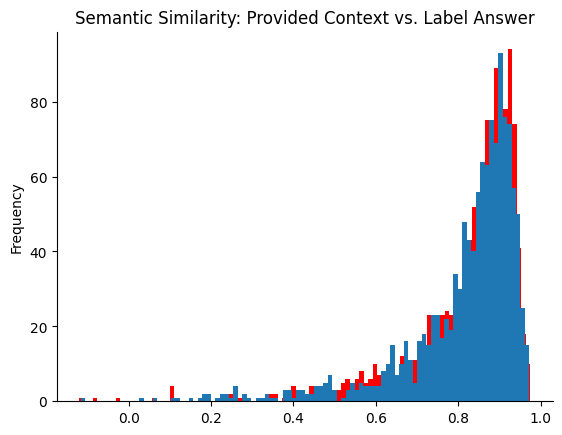

In [ ]:
from matplotlib import pyplot as plt
new_eval_df['context_answer_sim'].plot(kind='hist', color='red', bins=00, title='Semantic Similarity: Newly Retrieved Context vs. Label Answer')
og_eval_df['context_answer_sim'].plot(kind='hist', bins=100, title='Semantic Similarity: Provided Context vs. Label Answer')

plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
eval_256_context_comp_df.count()

index                        9
q_id                         9
question                     9
og_context                   9
og_predicted                 9
og_label                     9
og_nli-roberta_label         9
og_nli-roberta_plot_vals     9
og_nli-roberta-max-score     9
new_context                  9
new_predicted                9
new_label                    9
new_nli-roberta_label        9
new_nli-roberta_plot_vals    9
new_nli-roberta-max-score    9
context_sim                  9
dtype: int64